 Initializing Spark

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Movie Analysis").getOrCreate()
sc = spark.sparkContext


Uploading and Extracting Dataset


In [ ]:
from google.colab import files

uploaded = files.upload()



Saving ml-latest-small.zip to ml-latest-small (1).zip


In [ ]:
!unzip ml-latest-small.zip

!ls ml-latest-small

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
links.csv  movies.csv  ratings.csv  README.txt	tags.csv


Creating SparkSession

In [ ]:
from pyspark.sql import SparkSession

# Initializing SparkSession
spark = SparkSession.builder \
    .appName("Movie Analysis") \
    .master("local[*]") \
    .getOrCreate()

# Print confirmation that Spark is running
print("SparkSession created successfully!")


SparkSession created successfully!


Loading MovieLens Data



In [ ]:
movies_df = spark.read.csv("ml-latest-small/movies.csv", header=True, inferSchema=True)
ratings_df = spark.read.csv("ml-latest-small/ratings.csv", header=True, inferSchema=True)
tags_df = spark.read.csv("ml-latest-small/tags.csv", header=True, inferSchema=True)
links_df = spark.read.csv("ml-latest-small/links.csv", header=True, inferSchema=True)


Displaying Sample Data


In [ ]:
movies_df.show(5)
ratings_df.show(5)
tags_df.show(5)
links_df.show(5)


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|


Converting Timestamp to Readable Format


In [ ]:
from pyspark.sql.functions import from_unixtime

ratings_df = ratings_df.withColumn("timestamp", from_unixtime(ratings_df.timestamp))
ratings_df.show(5)


+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      1|   4.0|2000-07-30 18:45:03|
|     1|      3|   4.0|2000-07-30 18:20:47|
|     1|      6|   4.0|2000-07-30 18:37:04|
|     1|     47|   5.0|2000-07-30 19:03:35|
|     1|     50|   5.0|2000-07-30 18:48:51|
+------+-------+------+-------------------+
only showing top 5 rows



Joining Movies and Ratings Data


In [ ]:
movie_ratings = ratings_df.join(movies_df, "movieId")
movie_ratings.show(5)


Finding Top 10 Movies by Average Rating


In [20]:
from pyspark.sql.functions import col, avg
top_movies = ratings_df.groupBy("movieId") \
    .agg(avg("rating").alias("avg_rating")) \
    .join(movies_df, "movieId") \
    .orderBy(col("avg_rating").desc()) \
    .limit(10)
top_movies.show()


+-------+----------+--------------------+--------------------+
|movieId|avg_rating|               title|              genres|
+-------+----------+--------------------+--------------------+
| 173963|       5.0|      Empties (2007)|              Comedy|
|  84273|       5.0|Zeitgeist: Moving...|         Documentary|
| 152711|       5.0|Who Killed Chea V...|         Documentary|
| 113829|       5.0|One I Love, The (...|Comedy|Drama|Romance|
|   5513|       5.0|Martin Lawrence L...|  Comedy|Documentary|
|    496|       5.0|What Happened Was...|Comedy|Drama|Roma...|
|     53|       5.0|     Lamerica (1994)|     Adventure|Drama|
| 142444|       5.0|   The Editor (2015)|Comedy|Horror|Mys...|
|   8911|       5.0|Raise Your Voice ...|             Romance|
| 147300|       5.0|Adventures Of She...|       Crime|Mystery|
+-------+----------+--------------------+--------------------+



Analyzing Popular Movie Genres


In [22]:
from pyspark.sql.functions import explode, split
genre_count = movies_df.withColumn("genre", explode(split(movies_df.genres, "\\|"))) \
    .groupBy("genre").count() \
    .orderBy("count", ascending=False)
genre_count.show()


+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama| 4361|
|            Comedy| 3756|
|          Thriller| 1894|
|            Action| 1828|
|           Romance| 1596|
|         Adventure| 1263|
|             Crime| 1199|
|            Sci-Fi|  980|
|            Horror|  978|
|           Fantasy|  779|
|          Children|  664|
|         Animation|  611|
|           Mystery|  573|
|       Documentary|  440|
|               War|  382|
|           Musical|  334|
|           Western|  167|
|              IMAX|  158|
|         Film-Noir|   87|
|(no genres listed)|   34|
+------------------+-----+



Converting Spark DataFrame to Pandas for Visualization

In [25]:
genre_df = genre_count.toPandas()
genre_df.head()


,genre,count
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596


Visualizing Genre Popularity

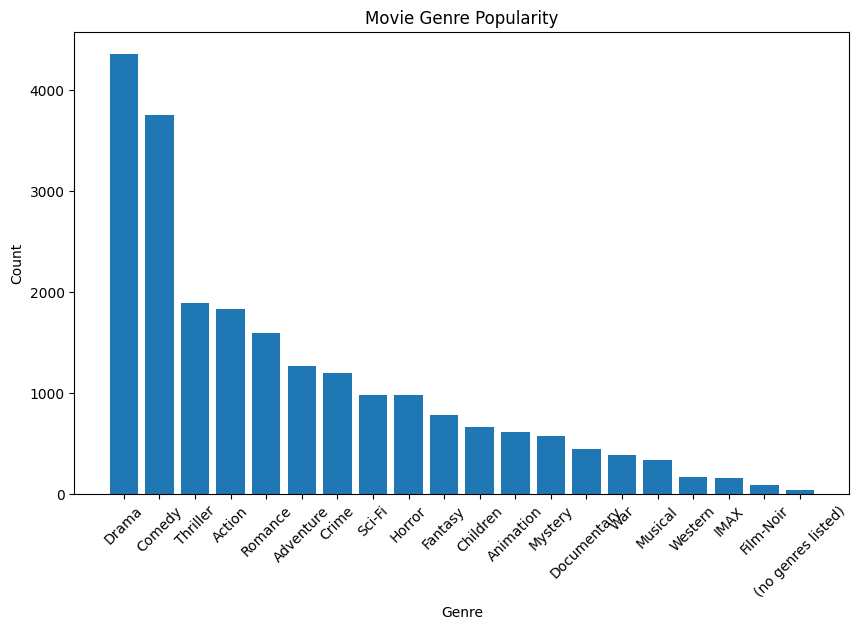

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.bar(genre_df['genre'], genre_df['count'])

plt.title("Movie Genre Popularity")

plt.xlabel("Genre")

plt.ylabel("Count")

plt.xticks(rotation=45)

plt.show()


Analyzing Rating Trends Over Time


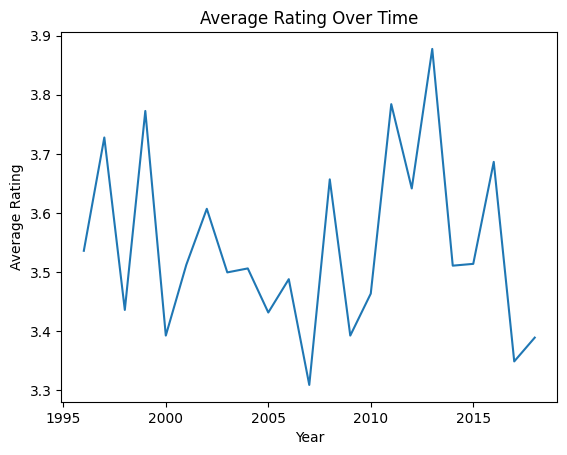

In [30]:
ratings_pd = movie_ratings.toPandas()

ratings_pd['timestamp'] = pd.to_datetime(ratings_pd['timestamp'])

ratings_pd.groupby(ratings_pd['timestamp'].dt.year)['rating'].mean().plot(kind='line')

plt.title("Average Rating Over Time")

plt.xlabel("Year")

plt.ylabel("Average Rating")

plt.show()


Convert Spark DataFrames to Pandas


In [38]:
top_movies_pd = top_movies.toPandas()

popular_genres_pd = genre_count.toPandas()

Plotting Top 10 Movies by Rating

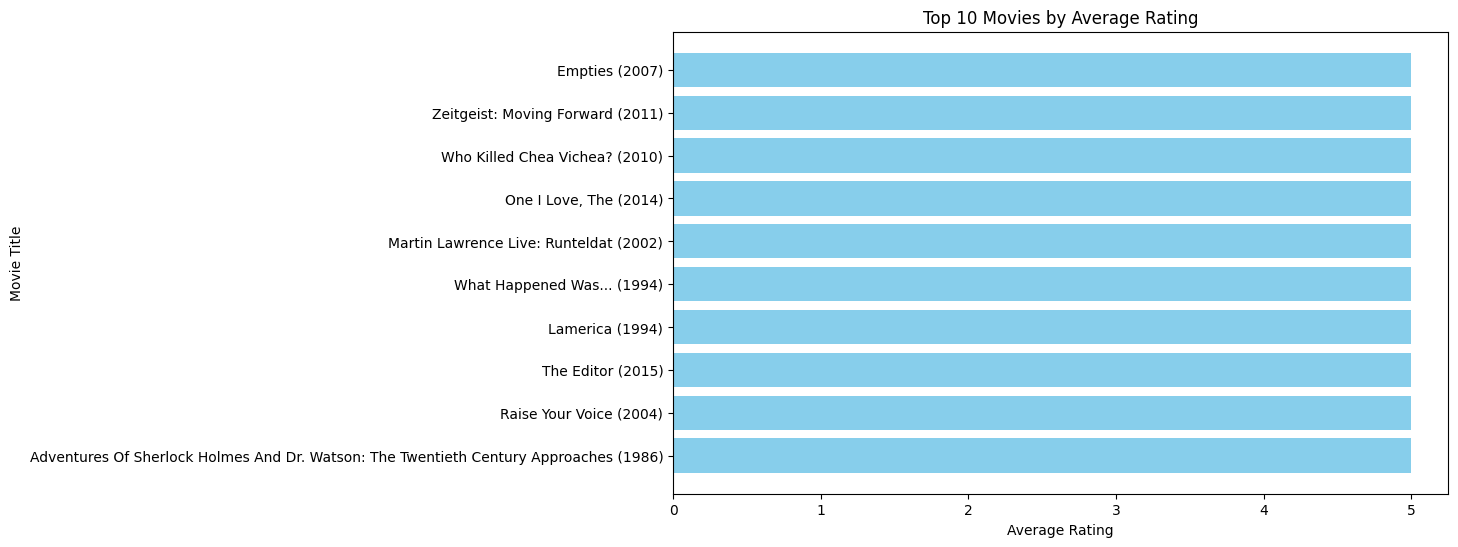

In [39]:

plt.figure(figsize=(10, 6))
plt.barh(top_movies_pd['title'], top_movies_pd['avg_rating'], color='skyblue')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Average Rating')
plt.gca().invert_yaxis()
plt.show()


average ratings for each movie

In [43]:
avg_ratings = ratings_pd.groupby("movieId")["rating"].mean().reset_index()

avg_ratings.rename(columns={"rating": "avg_rating"}, inplace=True)



Merge with movies dataset to get movie titles

In [44]:
movies_ratings_pd = avg_ratings.merge(movies_pd, on="movieId")

Select the lowest-rated movies

In [45]:
low_rated_pd = movies_ratings_pd.nsmallest(10, "avg_rating")

Plotting Lowest-Rated Movies

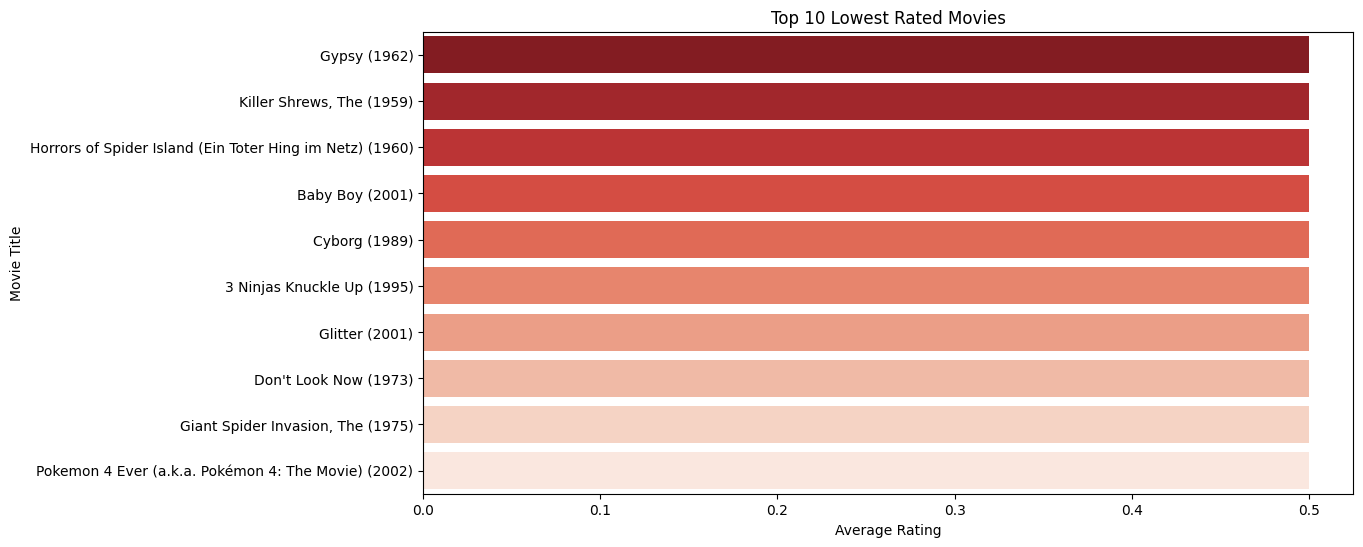

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Create the barplot
sns.barplot(y=low_rated_pd["title"], x=low_rated_pd["avg_rating"], palette="Reds_r", hue=low_rated_pd["title"], legend=False)

# Labeling the plot
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.title("Top 10 Lowest Rated Movies")

# Display the plot
plt.show()



In [52]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator


Prepare Data for ALS

In [53]:
# Splitting data into training (80%) and testing (20%)
(training, test) = ratings_df.randomSplit([0.8, 0.2], seed=42)


Train ALS Model

In [54]:
# Initialize ALS Model
als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    nonnegative=True,
    implicitPrefs=False,
    coldStartStrategy="drop"
)

# Train the model
model = als.fit(training)


Make Predictions on Test Data


In [55]:
predictions = model.transform(test)
predictions.show(5)


+------+-------+------+-------------------+----------+
|userId|movieId|rating|          timestamp|prediction|
+------+-------+------+-------------------+----------+
|   463|   1088|   3.5|2006-04-19 15:21:36|  3.807261|
|   580|   3175|   2.5|2007-01-03 02:51:14| 3.4962046|
|   580|  44022|   3.5|2007-01-03 02:49:20|  3.380546|
|   362|   1645|   5.0|2018-07-03 18:11:25| 3.6567898|
|   597|   1959|   4.0|1999-11-03 14:40:06|  4.114715|
+------+-------+------+-------------------+----------+
only showing top 5 rows



Evaluate Model Performance

In [56]:
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.8740378980393052


 Movie Recommendations for Users

In [57]:
user_recommendations = model.recommendForAllUsers(5)
user_recommendations.show(5, truncate=False)


+------+-----------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                      |
+------+-----------------------------------------------------------------------------------------------------+
|1     |[{177593, 5.7426257}, {132333, 5.725768}, {7121, 5.7169094}, {5915, 5.6653543}, {2843, 5.593874}]    |
|2     |[{131724, 4.8816476}, {26133, 4.8075523}, {32892, 4.7933235}, {106100, 4.7630877}, {8235, 4.7258673}]|
|3     |[{26865, 5.1931725}, {6835, 4.939668}, {5746, 4.939668}, {5181, 4.851598}, {4518, 4.7887177}]        |
|4     |[{132333, 5.197637}, {25947, 5.125216}, {4406, 5.1166673}, {8542, 5.060786}, {26326, 5.028}]         |
|5     |[{89904, 4.959016}, {177593, 4.824064}, {1104, 4.7174153}, {132333, 4.7108307}, {89759, 4.6952524}]  |
+------+-----------------------------------------------------------------------------------------------------+
o